# Polygenic Score prediction of Gross Domestic Product using Arabidopsis thaliana GWAS
This was born out of an undergraduate course on Computational Genetics, in which I teach about GWAS. As GWAS is a technology that is built on correlative relations I like to try to do bad things with it. As always-- correlation _does not equal_ causation. Recently the use of Polygenic scores (PGS) has become a popular way of doing phenotypic prediction from genotype data. PGS, at their most basic, are a sum of GWAS estimated effect sizes for an individual's genotype. 

In this notebook I develop a PGS predictor of Gross Domestic Product (GDP) of the country of origin of Arabidopsis thaliana accessions. I do this by treating GDP as a phenotype and then performing GWAS for that phenotype using a set of Arabidopsis genomes. All of the data for this comes from the [1001 Genomes dataset](http://1001genomes.org/index.html), its associated metadata, and GDP data that I gleaned from [here](https://datahub.io).


In [2]:
# imports for this notebook
import sys
import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd
import h5py
from matplotlib import pylab as plt
import seaborn as sns
import limix
sns.set_style('darkgrid')


all the _A. thaliana_ phenotype and genotype data is shoved in an hdf5 file that I've provided in the data directory

In [3]:
# get phenotype data
f = h5py.File("data/araTha.hdf5", 'r')

# metadata
meta = pd.read_csv("data/araThal_meta.csv")
meta.index = meta.pk


# data clean up here
countries = {
    'GER':'Germany',
    'US':'United States',
    'UK':'United Kingdom',
    'POR':'Portugal',
    'LIB':'Libya',
    'SUI':'Switzerland',
    'NED':'Netherlands',
    'DEN':'Denmark',
    'GRE':'Greece',
    'BUL':'Bulgaria',
    'CRO':'Croatia'
}
meta.country = meta.country.replace(countries)

# add GDP
gdp = pd.read_csv("data/gdp.csv")
gdp = gdp[gdp['Year'] == 2015]
gdp = gdp.rename(columns={'Country Name':'country'})
#print(gdp.country.unique())
gdp = gdp.rename(columns={'Value':'GDP'})
gdp_df = pd.merge(meta, gdp, on="country", how='left') 
gdp_df = gdp_df[['pk','name','country','GDP','longitude','latitude']]
gdp_df.index = gdp_df.pk
gdp_df = gdp_df.dropna()

## Where are the samples from?
let's quickly take a look at where these samples were collected

In [29]:
import folium
m = folium.Map(location=[0, 40], zoom_start=1)
for index, row in gdp_df.iterrows():
    if not np.isnan(row.longitude):
        # print([row.longitude, row.latitude])
        folium.Marker([row.latitude, row.longitude],popup=row.country).add_to(m)
m

## Grab the genotypes

In [4]:
geno_group = f['genotype']
# artifically thinning to every 5th SNP as I want it to run fast
# for class
thin = 5
chromosomes = geno_group['col_header']['chrom'][::thin]
positions = geno_group['col_header']['pos'][::thin]
geno_df = pd.DataFrame(geno_group['matrix'][:,::thin], columns=positions, 
                       index=geno_group['row_header']['sample_ID'][:],
                      dtype='float64')
print(f"shape of geno_df: {geno_df.shape}")

# get intersection index array
sample_idx = geno_df.index.intersection(gdp_df.index)
print(f"shape of intersection is {sample_idx.shape}")
snps = geno_df.loc[sample_idx]
print(f"shape of snp matrix {snps.shape}")
geno_df.head()

shape of geno_df: (1179, 42911)
shape of intersection is (1158,)
shape of snp matrix (1158, 42911)


657       6063      7601      10969     13045     21128     25365     \
6122       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
6121       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
6119       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
6116       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
6115       1.0       0.0       0.0       0.0       0.0       0.0       0.0   

      28978     31926     35856     ...  26947405  26951228  26955824  \
6122       0.0       1.0       1.0  ...       0.0       0.0       1.0   
6121       0.0       0.0       0.0  ...       0.0       0.0       0.0   
6119       0.0       0.0       1.0  ...       1.0       0.0       0.0   
6116       0.0       0.0       0.0  ...       0.0       1.0       0.0   
6115       0.0       0.0       0.0  ...       0.0       0.0       1.0   

      26957649  26961710  26964341  26965354  26969880  26971995  26973598  
6122       0.0       0.0       0.0       0.0       1.0       1.0       0.0  
6121       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
6119       1.0       0.0       0.0       0.0       0.0       0.0       0.0  
6116       1.0       0.0       0.0       0.0       0.0       0.0       1.0  
6115       0.0       0.0       0.0       0.0       1.0       1.0       0.0  

[5 rows x 42911 columns]

(array([  4.,   0.,   4.,   3.,  58., 356.,  22., 521.,   3., 187.]),
 array([-3.99136453, -3.4244467 , -2.85752887, -2.29061104, -1.72369322,
        -1.15677539, -0.58985756, -0.02293973,  0.5439781 ,  1.11089592,
         1.67781375]),
 <a list of 10 Patch objects>)

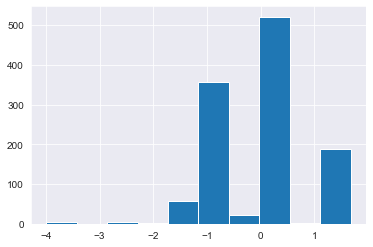

In [5]:
# log transform and Z standardize GDP
phenotype_std = np.log(gdp_df.GDP.loc[sample_idx].values)
phenotype_std -= np.mean(phenotype_std)
phenotype_std /= np.std(phenotype_std)
plt.hist(phenotype_std)

So our phenotype is cleaned up a bit for regression, looking vaguely normalish. Now let's unleash the raw power of **GWAS**

## Split our data for hold out comparison
I'm going to split the data into a training set for doing the GWAS and estimating effect sizes ($\beta$s) and a test set to check out the accuracy of the eventual PGS predictor. The test set will _not_ be used for any sort of model fitting and so will remain a clean set of data for us to fairly tests the accuracy of our predictions.

In [6]:
# test train split
from sklearn.model_selection import train_test_split

snps_train, snps_test, pheno_train, pheno_test = train_test_split(
    snps.values, phenotype_std, test_size=0.2, random_state=666)

# Hit the switch!

In [7]:
# run GWAS
g = limix.qtl.scan(snps_train,pheno_train,verbose=False)

GWAS complete. Now let's look at a QQ Plot 

Text(0.5, 1.0, 'GDP QQ Plot')

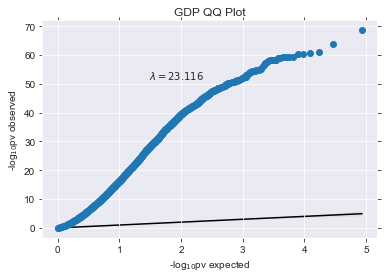

In [8]:
# gimme that sweet sweet inflation
limix.plot.qqplot(g.stats.pv20)
plt.title("GDP QQ Plot")

**note:** anyone reasonable would stop at this point and say, hey something doesn't look right. But the whole point of this notebook is to be _unreasonable_

# Manhattan plots
Let's see some peaks!

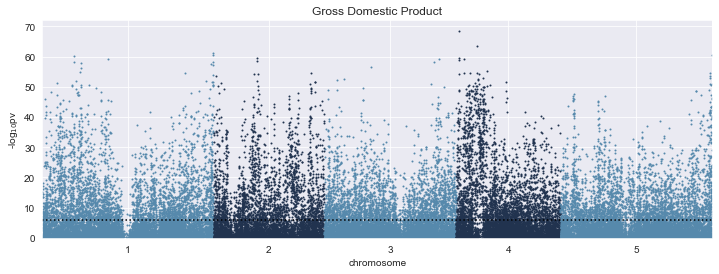

In [10]:
plt.figure(figsize=[12,4])
plt.title("Gross Domestic Product")
limix.plot.manhattan(pd.DataFrame(dict(pv=g.stats.pv20,chrom=chromosomes,pos=positions)))
bc = 0.05 / len(g.stats.pv20)
plt.axhline(-np.log10(bc), color='black', linestyle=":")

I see peaks and so LD is telling us where the real hits are right?

# Polygenic Score 
So we've gone our GWAS, let's do what comes naturally and create a genetic prediction method using a Polygenic score from our estimated $\beta$s (and then patent it for profitz). We will do the dumbest thing and just sum the effect sizes across all genotypes such that
$$
PGS = \sum_i^L x_i \beta_i
$$
where L is the number of loci, $x_i$ is the genotype of our individual at the $i$th locus and $\beta_i$ is the effect size estimated from GWAS of the $i$th locus

In [11]:
# naive PGS
def polygenic_score(genotype, betas):
    """
    simply the sum of the effect sizes
    across all loci
    """
    return(np.sum(np.multiply(genotype,betas)))


to use our PGS we will need to pull the $\beta$ vector out of the GWAS result object

Text(0, 0.5, 'density')

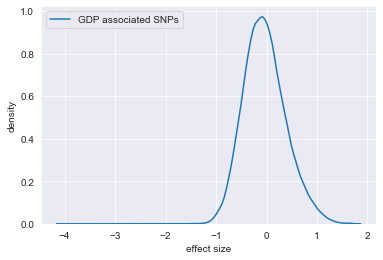

In [12]:
# get betas out of GWAS
betas_mask = g.effsizes['h2']['effect_type'] == 'candidate'
betas = g.effsizes['h2'][betas_mask]
# visualize the distributions
sns.kdeplot(betas.effsize)
plt.legend(["GDP associated SNPs"])
plt.xlabel("effect size")
plt.ylabel("density")

so distributed about zero, but with some larger effects both positive and negative

## Compute the PGS
lastly we will compute the PGS for each of the genotypes that we have held out in the test set. This should give us a fair indication of how "well" our genetic predictor is working

r-squared: 0.6385596601753731 p-value: 9.79854546646077e-53


Text(0, -2, '$R^2 = 0.64$')

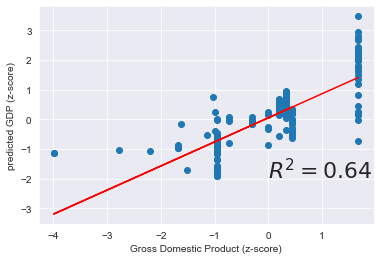

In [13]:
# compute the PGS scores for the
# held out test set
n = snps_test.shape[0]
pgs = np.zeros(n)
for i in range(n):
    pgs[i] = polygenic_score(snps_test[i,:],betas.effsize.values)

# standardize PGS for viz
pgs -= np.mean(pgs)
pgs /= np.std(pgs)
plt.scatter(pheno_test, pgs)
plt.xlabel("Gross Domestic Product (z-score)")
plt.ylabel("predicted GDP (z-score)")

slope, intercept, r_value, p_value, std_err = st.linregress(pheno_test,pgs)
print(f'r-squared: {r_value **2} p-value: {p_value}')

preds = [ intercept + (slope * x) for x in pheno_test]
plt.plot(pheno_test,preds,color='red')
plt.text(0,-2,r'$R^2 = {}$'.format(round(r_value **2,2)), fontsize=22)

## Step 3-- Profit
So we are able to get EXCELLENT predictions of GDP from Arabidopsis genomes. What does this mean? Well nothing really. It's just a reminder that PGS and GWAS say nothing about causality-- instead they are completely correlative!

However if you are an angel investor interested in supporting new startups in the geno-economic augury space-- please reach out to me. 

## Addendum
Graham Coop suggested that I preform a correction for population structure and try to see how much of the signal that removes. I'll do that first using a PCA of the genotypes and using PCs as covariates in my regression

In [14]:
# get PCA
from sklearn.decomposition import PCA
pc = PCA()
pc_snps = pc.fit_transform(snps_train)

do GWAS with top 10 PCs as covariates, plot QQ plot. 

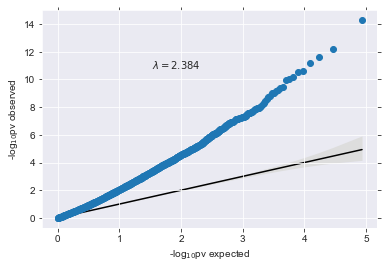

In [22]:
keep = 10
covs_with_pcs = sp.concatenate([sp.ones([snps_train.shape[0],1]),pc_snps],axis=1)
_covs = covs_with_pcs[:,0:keep+1]
# print(_covs.shape,snps.values.shape,phenotype_std.shape)
g_corr = limix.qtl.scan(snps_train, pheno_train, M=_covs, verbose=False)
limix.plot.qqplot(g_corr.stats.pv20)

now let's compare the effect size distribution of corrected vs uncorrected GWAS

Text(0, 0.5, 'density')

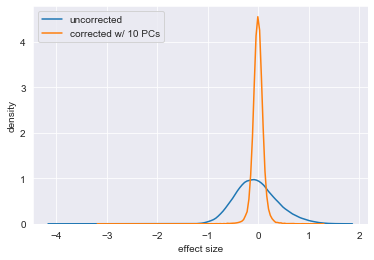

In [24]:
# get betas out of GWAS
betas_mask = g_corr.effsizes['h2']['effect_type'] == 'candidate'
betas_corr = g_corr.effsizes['h2'][betas_mask]
# visualize the distributions
sns.kdeplot(betas.effsize)
sns.kdeplot(betas_corr.effsize)
plt.legend(["uncorrected","corrected w/ 10 PCs"])
plt.xlabel("effect size")
plt.ylabel("density")

so as we would expect, by correcting for population structure we are pushing the $\beta$s towards zero.

### PC corrected PGS
Okay finally we'll compute the PGS for held out samples using the population structure corrected GWAS

r-squared: 0.14026265359803827 p-value: 3.876087916025445e-09


Text(-3, 3, '$R^2 = 0.14$')

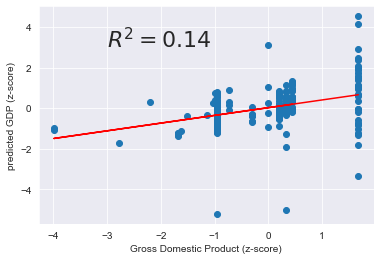

In [28]:
# compute the PGS scores 
# using the corrected betas
n = snps_test.shape[0]
pgs = np.zeros(n)
for i in range(n):
    pgs[i] = polygenic_score(snps_test[i,:],betas_corr.effsize.values)

# standardize PGS for viz
pgs -= np.mean(pgs)
pgs /= np.std(pgs)
plt.scatter(pheno_test, pgs)
plt.xlabel("Gross Domestic Product (z-score)")
plt.ylabel("predicted GDP (z-score)")

slope, intercept, r_value, p_value, std_err = st.linregress(pheno_test,pgs)
print(f'r-squared: {r_value **2} p-value: {p_value}')

preds = [ intercept + (slope * x) for x in pheno_test]
plt.plot(pheno_test,preds,color='red')
plt.text(-3,3,r'$R^2 = {}$'.format(round(r_value **2,2)), fontsize=22)

again as we expect, using the top 10 PCs as covariates in our regression fixes a good bit, but not all of the issue of confounding population structure